In [2]:
import math
import scipy.constants
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model as mdl
from numpy import genfromtxt
import skimage
from scipy.signal import savgol_filter
### update with functions from simulation script ###

# BLW 26-08-25
# make into a clean notebook for release

# This script has functions to simulate 1D and 2D CTFs, and create simulated through-focus series
# The CTF can be varied as a function of defocus, Cc, Cs, and kV
# The maximum spatial frequency is set as flim
# The image size for 2D CTFs is set, and the pixel size worked out from the maximum spatial frequency
# To add: functions to do LS fit to experimental CTF data

In [19]:
# define functions
# 1D CTF
def calculate_CTF( defocus, lamb, Cs, flim, fno ):
    CTF = [0 for _ in range(fno)]
    frequency = [0 for _ in range(fno)]
    frequency = [0 for _ in range(fno)]
    for i in n:
        f = float( (flim) * i/fno ) #float(flim*(i/fno))
        CTF[i] = np.sin((np.pi*defocus*lamb*(f**2)) +(0.5*np.pi*Cs*(lamb**3)*(f**4)))#Carter and Williams
        frequency[i] = f
    return CTF, frequency

# Aperture function
def aperture_function( cutoff, CTF, frequency ):
    aperture = np.zeros(len(CTF))
    n = range(0, len(aperture ))
    for i in n:
        if frequency[i] < cutoff:
            aperture[i] = 1
        if frequency[i] >= cutoff:
            aperture[i] = 0
    return aperture

def temporal_coherence( focal_spread, kV, CTF, flim, fno, Cc ):
    # in eV
    #deltaE = 1.5 #1.5 for 2100plus
    # current
    #deltaI = 1
    #I = 1
    # volts
    #deltaV = 2e-6  #2e-6 # for plus2e-6
    V = kV * 1000
    #delta = Cc * np.sqrt( 4* ((deltaI/I)**2) * ((deltaE/V)**2) * ((deltaV/V)**2) )# spatial units
    delta = Cc * (focal_spread / V)
    Et = np.zeros(len(CTF))
    n = range(0, len( Et ))
    for i in n:
        f = float(flim*(i/fno))
        Et[i] = np.exp( -0.25*(( np.pi* lamb * delta)**2) * f**4)
    return Et

def spatial_coherence( beta, defocus, CTF, lamb, Cs, flim, fno ):
    Es = np.zeros(len(CTF))
    
    dChi = np.zeros(len(CTF))
    
    n = range(0, len( Et ))
    for i in n:
        f = float(flim*(i/fno))
        # Williams and Carter
        dChi[i] = (2*np.pi*lamb*f*defocus) + (2*np.pi*Cs*(lamb**3)*(f**3))# really small numbers for some reason
        Es[i] = np.exp( -(beta / ((4*(lamb**2)))) * abs(dChi[i])**2 )
    return Es

# calculate relativistic wavelength from kV 
def kVToLamb(E):
    #lamb = 1.23e3/(math.sqrt(E*(1+9.78e-7*E)))
    E = E*1000
    PT = scipy.constants.h * scipy.constants.c
    PBA = (scipy.constants.e *E)*(scipy.constants.e *E)
    PBB = 2*scipy.constants.e*E*scipy.constants.m_e*(scipy.constants.c)*(scipy.constants.c)
    lamb = PT/math.sqrt(PBA+PBB)#lambda in metres
    return(lamb)

def calculate_scherzer( Csmm, lamb ):
    Cs = Csmm/1000
    scherzer = np.sqrt((4/3)*Cs*lamb)
    return scherzer

def normaliseDataRange( data, **kwargs ):
    dmin = kwargs.get('dmin', 0)
    dmax = kwargs.get('dmax', 1)
    return ((data-np.min(data))/(np.max(data)-np.min(data)))*( dmax - dmin )

In [20]:
def CTF( g, lamb, defocus, Cs, C12a, C12b, phi ):
    func = np.sin(np.pi*lamb*(g**2)*(defocus + C12a*np.cos(2*phi) + C12b*np.sin(2*phi) ) +(0.5*np.pi*Cs*(lamb**3)*(g**4)))**2
    return func

def fit_CTF( ydata, xdata, **kwargs ):
    # kwargs
    kV = kwargs.get('voltage', 200)
    fit_defocus = kwargs.get('fit_defocus', False)
    fit_Cs = kwargs.get('fit_Cs', False)
    kV = kwargs.get('voltage', 200)
    defocus_val = kwargs.get('defocus', 0) * 1e-9
    Cs_val = kwargs.get('Cs', 1.6) *1e-3
    Cs_bounds = kwargs.get('Cs_bounds', [-np.inf, np.inf]) * 1e-3
    defocus_bounds = kwargs.get('defocus_bounds', [-np.inf, np.inf]) * 1e-9
    # convert to SI units
    lamb = kVToLamb( kV )
    #ydata = normaliseDataRange( ydata )
    print( fit_Cs )
    # make model
    model = mdl(CTF)
    params = model.make_params( defocus=defocus_val, Cs=Cs_val, lamb=lamb, C12a=0, C12b=0, phi=0  )
    #print(f'independent variables: {model.independent_vars}')
    params['Cs'].vary = fit_Cs
    params['Cs'].min = Cs_bounds[0]
    params['Cs'].max = Cs_bounds[1]
    params['defocus'].vary = fit_defocus
    params['lamb'].vary = False
    # do fitting
    results = model.fit(ydata, params, g=xdata )
    # report the fit results
    print(results.fit_report(show_correl=False))
    print( 'Cs: ' + str( results.params['Cs'].value * 1e3 ) + ' mm' )
    print( 'Defocus: ' + str( results.params['defocus'].value * 1e9 ) + ' nm' )
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,5)))
    fig, ax  = plt.subplots(1,1)
    #ydata = scaleDataRange( ydata, dmin=0, dmax=1 )
    ax.plot(data[0:,0], data[0:,1], label='full range', linestyle='--')
    ax.plot(xdata/1e9, ydata, label='experimental')
    ax.plot(xdata/1e9, results.best_fit, label='best fit')
    ax.set_box_aspect(1)
    ax.set_title("Fit")
    fig.legend(loc='lower right')
    fig.tight_layout()
    ax.set_ylabel('Intensity', fontsize = 16)
    ax.set_xlabel('Frequency / nm-1', fontsize = 16)
    #ax.set_ylim([0,1])
    ax.set_xlim([0,4])
    return results.best_fit

In [47]:
# find CTF zeros 
def find_CTF_zeros( data ):
    minima, _ = scipy.signal.find_peaks(-data)
    maxima, _ = scipy.signal.find_peaks(data)
    return maxima, minima

def gradient_simple(x, m, c):
    y = m*x + c
    return y

def fit_gradient(x_min, y_min):
    from numpy.polynomial import polynomial as P
    [intercept, slope] = P.polyfit(x_min, y_min, 1, full=False )
    # covariance
    cov = np.sqrt(np.diagonal(np.cov(x_min, y_min)))
    lamb = 0.00251e-9
    ## Cs and defocus
    Cs = slope/(lamb**3)
    print("Cs = " + str(Cs*1e3) + " nm")
    defocus = -intercept/(-2*lamb)
    print("Defocus = " + str(defocus*1e9) + "+/-" + " nm")
    return intercept, slope

#baseline smoothing from: https://stackoverflow.com/questions/29156532/python-baseline-correction-library
# p (0.1 - 0.001) is for asymmetry, lambda (100 - 1000) is for smoothness
def baseline_als(y, lam, p, niter=10):
    from scipy import sparse
    from scipy.sparse.linalg import spsolve
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def plotCsFigure( data, xdata, ydata, x_min, y_min, results ):
    fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(8,8))
    fig.tight_layout()
    ax1.plot(data[0:,0], data[0:,1], label='full range', linestyle='--', alpha=0.4)
    ax1.plot(xdata/1e9, ydata)
    ax1.plot(xdata[minima]/1e9, ydata[minima], "x")
    ax1.plot(xdata[maxima]/1e9, ydata[maxima], "x")
    
    ax1.set_box_aspect(1)
    ax1.set_title("Fit")
    ax1.set_ylabel('Intensity', fontsize = 16)
    ax1.set_xlabel('Frequency / nm-1', fontsize = 16)
    ax1.set_xlim([0,4])
    ax1.set_ylim([None,0.1])
    
    ax2.plot(x_min/1e18, y_min*1e18,"x",  label="minima")
    ax2.plot(x_min/1e18, results.best_fit, label='best fit')
    #ax2.plot( x_min/1e18, gradient_simple(x_min, slope, intercept)*1e18 )
    ax2.set_box_aspect(1)
    ax2.set_ylabel('$n/k_{n}^2 / nm^2$', fontsize = 16)
    ax2.set_xlabel('$k_{n}^2 / nm^{-2}$', fontsize = 16)
    return fig, ax1, ax2

def Cs_gradient( x, m ,c ):
    y = m*x + c
    return y

# work out whats going on with the units
# only works if you make it in nm
def fit_Cs_and_defocus( x_min, y_min, lamb ):
    # fitting
    model = mdl(Cs_gradient)
    params = model.make_params( )
    params['m'].value = -1.0
    params['m'].vary = True
    params['m'].min = -1.0
    params['m'].max = 1.0
    params['c'].value = 0.0
    params['c'].vary = True
    #params['c'].min = 0
    #params['c'].max = 1.0
    results = model.fit(y_min*1e18, params, x=x_min*1e-18 )
    Cs = results.params['m'].value/(lamb**3)
    defocus = -1*results.params['c'].value/(-2*lamb)
    print("Cs = " + str(Cs*1e-6) + " mm")
    print("Defocus = " + str(defocus) + " nm")
    return results

Cs = 1.3826743282203107 nm
Defocus = -421.11968247689555+/- nm
Cs = 1.3826743282202574 mm
Defocus = -421.1196824768958 nm
[[Model]]
    Model(Cs_gradient)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 8
    # variables        = 2
    chi-square         = 5.0289e-04
    reduced chi-square = 8.3815e-05
    Akaike info crit   = -73.3966828
    Bayesian info crit = -73.2377997
    R-squared          = 0.97743632
[[Variables]]
    m:  0.02186458 +/- 0.00135623 (6.20%) (init = -1)
    c: -2.11402081 +/- 0.00694207 (0.33%) (init = 0)


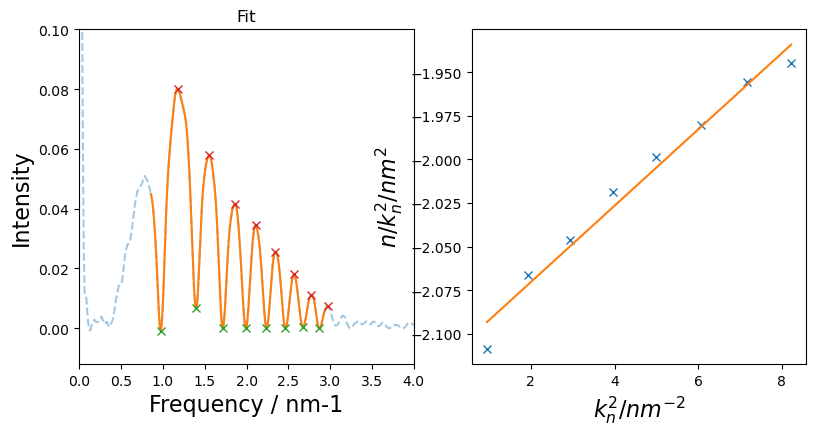

In [48]:
data = genfromtxt('FEG_CTFs\\FEG_CTF_32134_200kV.msa', delimiter=',')

# fitting bounds, lower then upper
# range of data to fit
data_bounds=(80, 280) #0, 350

#remove baseline
baseline = baseline_als( data[0:, 1], 100, 0.0001 )
data[0:,1] = data[0:,1]-baseline

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

# smooth ydata
ydata = savgol_filter( ydata, 5, 2, axis=-1, deriv=0, mode='interp')

# find maxima and minima, in nm-1
maxima, minima = find_CTF_zeros( ydata )

#filter badly detected points
minima = np.array([x for x in minima if ydata[x] <= 1.0e9])
minima = np.array([x for x in minima if xdata[x] <= 3.0e9])

indi_min = np.array( list( range( -2, -len( minima )*2-2, -2 ) ) )
x_min = (xdata[minima])**2
y_min = (indi_min)/(xdata[minima]**2)

indi_max = np.array( list( range( -3, -len( maxima )*2-2, -2 ) ) )
x_max = (xdata[maxima])**2
y_max = (indi_max)/(xdata[maxima]**2)

# fitting
intercept, slope = fit_gradient( x_min, y_min )

Cs_fit = fit_Cs_and_defocus( x_min, y_min, 0.00251 )
#plt.plot(x_min*1e-18, y_min*1e18, "x")

# results
print(Cs_fit.fit_report(show_correl=False))
fig, ax1, ax2 = plotCsFigure( data, xdata, ydata, x_min, y_min, Cs_fit )

CTF_zeros_32134 = np.stack( [x_min, y_min] )

Cs = 1.2073226666300623 nm
Defocus = -505.0583937481914+/- nm
Cs = 1.2073226666305483 mm
Defocus = -505.0583937481875 nm
[[Model]]
    Model(Cs_gradient)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 10
    # variables        = 2
    chi-square         = 0.00128416
    reduced chi-square = 1.6052e-04
    Akaike info crit   = -85.6023321
    Bayesian info crit = -84.9971619
    R-squared          = 0.94340730
[[Variables]]
    m:  0.01909170 +/- 0.00165322 (8.66%) (init = -1)
    c: -2.53539314 +/- 0.00850489 (0.34%) (init = 0)


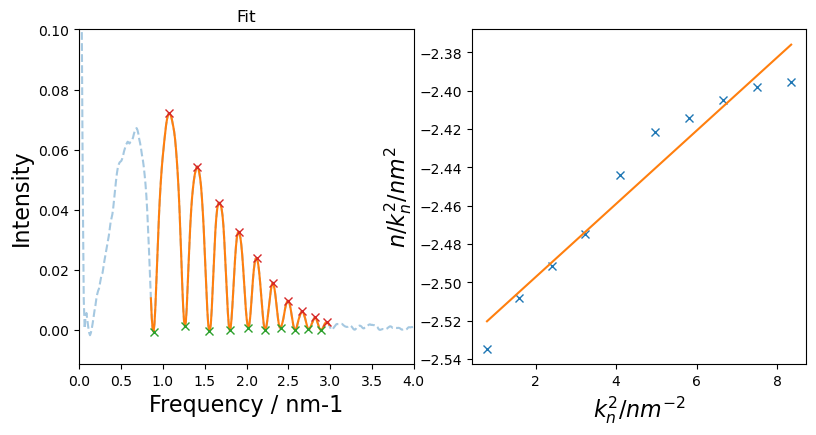

In [49]:
data = genfromtxt('FEG_CTFs\\FEG_CTF_32135_200kV.msa', delimiter=',')

# fitting bounds, lower then upper
# range of data to fit
data_bounds=(80, 280) #0, 350

#remove baseline
baseline = baseline_als( data[0:, 1], 100, 0.0001 )
data[0:,1] = data[0:,1]-baseline

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

# smooth ydata
ydata = savgol_filter( ydata, 5, 2, axis=-1, deriv=0, mode='interp')

# find maxima and minima, in nm-1
maxima, minima = find_CTF_zeros( ydata )

#filter badly detected points
minima = np.array([x for x in minima if ydata[x] <= 1.0e9])
minima = np.array([x for x in minima if xdata[x] <= 3.0e9])

indi_min = np.array( list( range( -2, -len( minima )*2-2, -2 ) ) )
x_min = (xdata[minima])**2
y_min = (indi_min)/(xdata[minima]**2)

indi_max = np.array( list( range( -3, -len( maxima )*2-2, -2 ) ) )
x_max = (xdata[maxima])**2
y_max = (indi_max)/(xdata[maxima]**2)

# fitting
intercept, slope = fit_gradient( x_min, y_min )

Cs_fit = fit_Cs_and_defocus( x_min, y_min, 0.00251 )
#plt.plot(x_min*1e-18, y_min*1e18, "x")

# results
print(Cs_fit.fit_report(show_correl=False))
fig, ax1, ax2 = plotCsFigure( data, xdata, ydata, x_min, y_min, Cs_fit )

CTF_zeros_32135 = np.stack( [x_min, y_min] )

Cs = 1.1693627850506707 nm
Defocus = -223.07622475554342+/- nm
Cs = 1.1693627850508286 mm
Defocus = -223.07622475554354 nm
[[Model]]
    Model(Cs_gradient)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 5
    # variables        = 2
    chi-square         = 5.3809e-05
    reduced chi-square = 1.7936e-05
    Akaike info crit   = -53.1975155
    Bayesian info crit = -53.9786397
    R-squared          = 0.99690217
[[Variables]]
    m:  0.01849143 +/- 5.9514e-04 (3.22%) (init = -1)
    c: -1.11984265 +/- 0.00412087 (0.37%) (init = 0)


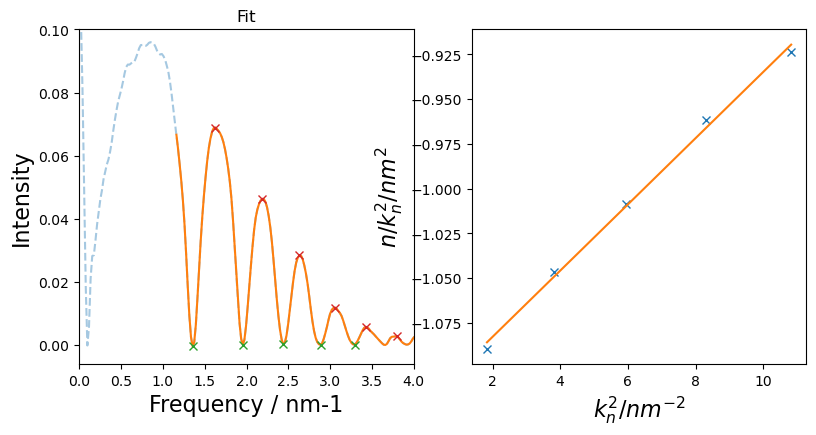

In [50]:
data = genfromtxt('FEG_CTFs\\FEG_CTF_32132_200kV.msa', delimiter=',')

# fitting bounds, lower then upper
# range of data to fit
data_bounds=(60, 280) #0, 350

#remove baseline
baseline = baseline_als( data[0:, 1], 100, 0.0001 )
data[0:,1] = data[0:,1]-baseline

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

# smooth ydata
ydata = savgol_filter( ydata, 5, 2, axis=-1, deriv=0, mode='interp')

# find maxima and minima, in nm-1
maxima, minima = find_CTF_zeros( ydata )

#filter badly detected points
minima = np.array([x for x in minima if ydata[x] <= 1.0e9])
minima = np.array([x for x in minima if xdata[x] <= 3.5e9])

indi_min = np.array( list( range( -2, -len( minima )*2-2, -2 ) ) )
x_min = (xdata[minima])**2
y_min = (indi_min)/(xdata[minima]**2)

indi_max = np.array( list( range( -3, -len( maxima )*2-2, -2 ) ) )
x_max = (xdata[maxima])**2
y_max = (indi_max)/(xdata[maxima]**2)

# fitting
intercept, slope = fit_gradient( x_min, y_min )

Cs_fit = fit_Cs_and_defocus( x_min, y_min, 0.00251 )
#plt.plot(x_min*1e-18, y_min*1e18, "x")

# results
print(Cs_fit.fit_report(show_correl=False))
fig, ax1, ax2 = plotCsFigure( data, xdata, ydata, x_min, y_min, Cs_fit )

CTF_zeros_32132 = np.stack( [x_min, y_min] )

Cs = 1.430043776070561 nm
Defocus = -486.46191313142185+/- nm
Cs = 1.4300437761340101 mm
Defocus = -486.4619131314221 nm
[[Model]]
    Model(Cs_gradient)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 11
    # variables        = 2
    chi-square         = 5.5785e-04
    reduced chi-square = 6.1983e-05
    Akaike info crit   = -104.782467
    Bayesian info crit = -103.986676
    R-squared          = 0.98808754
[[Variables]]
    m:  0.02261364 +/- 8.2767e-04 (3.66%) (init = -1)
    c: -2.44203880 +/- 0.00494759 (0.20%) (init = 0)


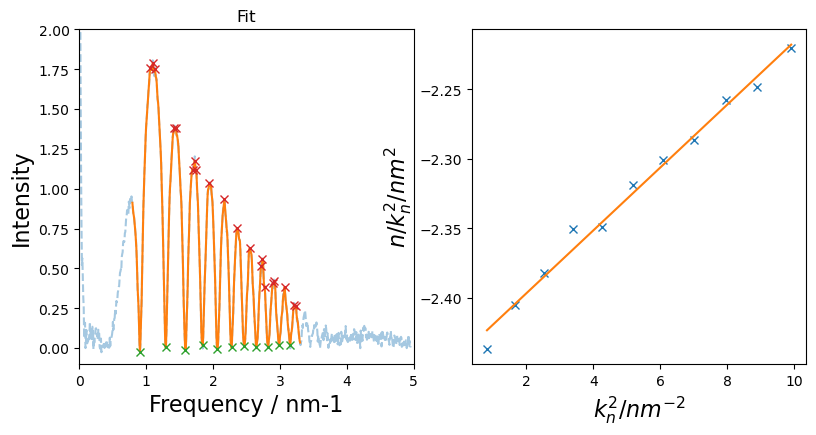

In [61]:
data = genfromtxt('FEG_CTFs\\FEG_CTF_41042_200kV.msa', delimiter=',')

# fitting bounds, lower then upper
# range of data to fit
data_bounds=(120, 500) #0, 350

#remove baseline
baseline = baseline_als( data[0:, 1], 100, 0.0001 )
data[0:,1] = data[0:,1]-baseline

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

# smooth ydata
ydata = savgol_filter( ydata, 5, 2, axis=-1, deriv=0, mode='interp')

# find maxima and minima, in nm-1
maxima, minima = find_CTF_zeros( ydata )

#filter badly detected points
minima = np.array([x for x in minima if ydata[x] <= 0.25])
minima = np.array([x for x in minima if xdata[x] <= 3.5e9])

indi_min = np.array( list( range( -2, -len( minima )*2-2, -2 ) ) )
x_min = (xdata[minima])**2
y_min = (indi_min)/(xdata[minima]**2)

indi_max = np.array( list( range( -3, -len( maxima )*2-2, -2 ) ) )
x_max = (xdata[maxima])**2
y_max = (indi_max)/(xdata[maxima]**2)

# fitting
intercept, slope = fit_gradient( x_min, y_min )

Cs_fit = fit_Cs_and_defocus( x_min, y_min, 0.00251 )
#plt.plot(x_min*1e-18, y_min*1e18, "x")

# results
print(Cs_fit.fit_report(show_correl=False))
fig, ax1, ax2 = plotCsFigure( data, xdata, ydata, x_min, y_min, Cs_fit )
ax1.set_xlim([0, 5])
ax1.set_ylim([-0.1, 2])

CTF_zeros_41042 = np.stack( [x_min, y_min] )

Cs = 1.3931879950682018 nm
Defocus = 421.32262040486523+/- nm


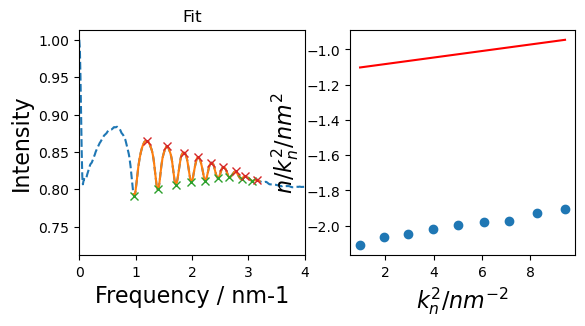

In [33]:
# find CTF zeros 
from scipy.signal import find_peaks

def find_CTF_zeros( data ):
    minima, _ = scipy.signal.find_peaks(-data)
    maxima, _ = scipy.signal.find_peaks(data)
    return maxima, minima

def gradient_simple(x, m, c):
    y = m*x + c
    return y

def fit_gradient(x_min, y_min):
    from numpy.polynomial import polynomial as P
    [intercept, slope] = P.polyfit(x_min, y_min, 1, full=False )
    # covariance
    cov = np.sqrt(np.diagonal(np.cov(x_min, y_min)))
    lamb = 0.00251e-9
    ## Cs and defocus
    Cs = slope/(lamb**3)
    print("Cs = " + str(Cs*1e3) + " nm")
    defocus = intercept/(-2*lamb)
    print("Defocus = " + str(defocus*1e9) + "+/-" + " nm")
    return

data = genfromtxt('FEG_CTFs\\FEG_CTF_32133_200kV.msa', delimiter=',')
# fitting bounds, lower then upper
# range of data to fit
data_bounds=(90, 300) #0, 350

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]
#ydata = scaleDataRange( ydata, dmin=0, dmax=1 )

# find maxima and minima, in nm-1
maxima, minima = find_CTF_zeros( ydata )

indicies_neg = [-2, -4, -6, -8, -10, -12, -14, -16, -18]

x_min = (xdata[minima])**2
#(indicies_neg*ydata[maxima]) )
y_min = (indicies_neg)/(xdata[minima]**2)

#indicies = np.concatenate( (indicies_neg, indicies_pos))

# fitting
fit_gradient( x_min, y_min )

fig, (ax1, ax2)  = plt.subplots(1,2)
#ydata = scaleDataRange( ydata, dmin=0, dmax=1 )
ax1.plot(data[0:,0], data[0:,1], label='full range', linestyle='--')
#ax.plot(xdata/1e9, ydata, label='experimental')

ax1.plot(xdata/1e9, ydata)
ax1.plot(xdata[minima]/1e9, ydata[minima], "x")
ax1.plot(xdata[maxima]/1e9, ydata[maxima], "x")

ax1.set_box_aspect(1)
ax1.set_title("Fit")
ax1.set_ylabel('Intensity', fontsize = 16)
ax1.set_xlabel('Frequency / nm-1', fontsize = 16)
#ax.set_ylim([0,1])
ax1.set_xlim([0,4])

ax2.scatter(x_min/1e18, y_min*1e18)
ax2.plot( x_min/1e18, gradient_simple(x_min, slope, intercept)*1e18, color='red' )
ax2.set_box_aspect(1)
ax2.set_ylabel('$n/k_{n}^2 / nm^2$', fontsize = 16)
ax2.set_xlabel('$k_{n}^2 / nm^{-2}$', fontsize = 16)

CTF_zeros_32133 = np.stack( [x_min, y_min] )

Cs = 1.6870510285013687 nm
Defocus = -711.8599685492298+/- nm
Cs = 1.687051028093037 mm
Defocus = -711.8599685492304 nm
[[Model]]
    Model(Cs_gradient)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 11
    # variables        = 2
    chi-square         = 0.00209610
    reduced chi-square = 2.3290e-04
    Akaike info crit   = -90.2212860
    Bayesian info crit = -89.4254954
    R-squared          = 0.92856587
[[Variables]]
    m:  0.02667776 +/- 0.00246641 (9.25%) (init = -1)
    c: -3.57353704 +/- 0.00972605 (0.27%) (init = 0)
[[ 5.59454783e+17  1.12446725e+18  1.70713823e+18  2.29483112e+18
   2.87221485e+18  3.44368187e+18  4.02886388e+18  4.61915521e+18
   5.24978532e+18  5.82896038e+18  6.48657227e+18]
 [-3.57490911e-18 -3.55724011e-18 -3.51465388e-18 -3.48609531e-18
  -3.48163370e-18 -3.48464244e-18 -3.47492504e-18 -3.46383685e-18
  -3.42871163e-18 -3.43114358e-18 -3.39162181e-18]]


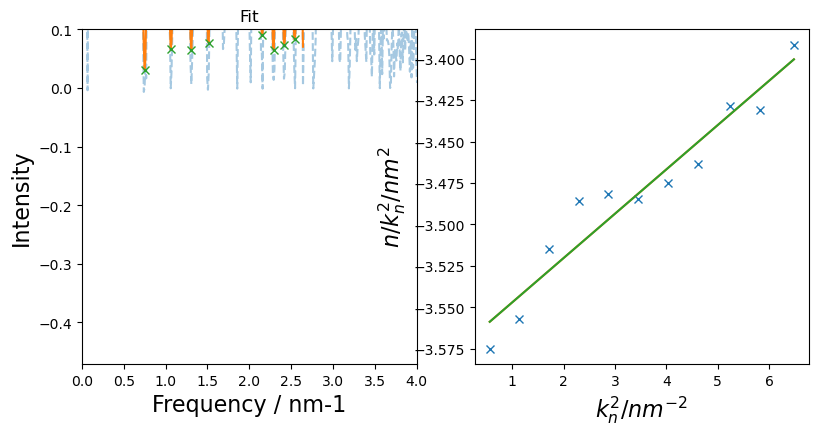

In [79]:
data = genfromtxt('FEG_Cc\\01_CTF.msa', delimiter=',')
# fitting bounds, lower then upper
# range of data to fit
data_bounds=(70, 280) #0, 350

#remove baseline
baseline = baseline_als( data[0:, 1], 100, 0.0001 )
data[0:,1] = data[0:,1]-baseline

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

# smooth ydata
ydata = savgol_filter( ydata, 5, 1, axis=-1, deriv=0, mode='interp')

# find maxima and minima, in nm-1
maxima, minima = find_CTF_zeros( ydata )

#filter badly detected points
minima = np.array([x for x in minima if ydata[x] <= 0.25])
minima = np.array([x for x in minima if xdata[x] <= 3.0e9])

indi_min = np.array( list( range( -2, -len( minima )*2-2, -2 ) ) )
x_min = (xdata[minima])**2
y_min = (indi_min)/(xdata[minima]**2)

indi_max = np.array( list( range( -3, -len( maxima )*2-2, -2 ) ) )
x_max = (xdata[maxima])**2
y_max = (indi_max)/(xdata[maxima]**2)

# fitting
intercept, slope = fit_gradient( x_min, y_min )

def Cs_gradient( x, m ,c ):
    y = m*x + c
    return y

Cs_fit = fit_Cs_and_defocus( x_min, y_min, 0.00251 )
#plt.plot(x_min*1e-18, y_min*1e18, "x")

# results
print(Cs_fit.fit_report(show_correl=False))
fig, ax1, ax2 = plotCsFigure( data, xdata, ydata, x_min, y_min, Cs_fit )

ax2.plot( x_min/1e18, gradient_simple(x_min, slope, intercept)*1e18 )

CTF_zeros_01 = np.stack( [x_min, y_min] )

print(CTF_zeros_01)

Cs = 2.7740233071237967 nm
Defocus = -1065.4762494357399+/- nm
Cs = -63.23810328439104 mm
Defocus = 0.0 nm
[[Model]]
    Model(Cs_gradient)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 10
    # variables        = 2
    chi-square         = 112.859544
    reduced chi-square = 14.1074431
    Akaike info crit   = 28.2355898
    Bayesian info crit = 28.8407600
    R-squared          = -2917.03587
[[Variables]]
    m: -1.00000000 +/- 8.3510e-12 (0.00%) (init = -1)
    c:  0.00000000 +/- 2.54649919  (init = 0)


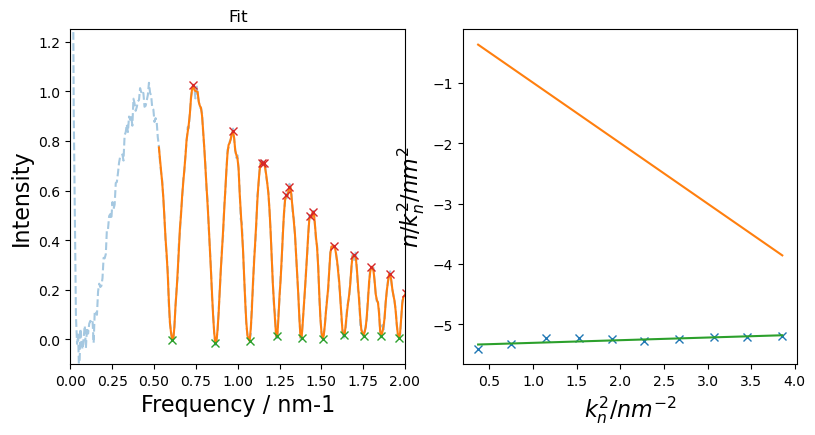

In [116]:
data = genfromtxt('FEG_CTFs\\focus_series_03\\39735.msa', delimiter=',')

# fitting bounds, lower then upper
# range of data to fit
data_bounds=(80, 500) #0, 350

#remove baseline
baseline = baseline_als( data[0:, 1], 100, 0.0001 )
data[0:,1] = data[0:,1]-baseline

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

# smooth ydata
ydata = savgol_filter( ydata, 5, 2, axis=-1, deriv=0, mode='interp')

# find maxima and minima, in nm-1
maxima, minima = find_CTF_zeros( ydata )

#filter badly detected points
minima = np.array([x for x in minima if ydata[x] <= 0.03])
minima = np.array([x for x in minima if xdata[x] <= 2.0e9])

indi_min = np.array( list( range( -2, -len( minima )*2-2, -2 ) ) )
x_min = (xdata[minima])**2
y_min = (indi_min)/(xdata[minima]**2)

indi_max = np.array( list( range( -3, -len( maxima )*2-2, -2 ) ) )
x_max = (xdata[maxima])**2
y_max = (indi_max)/(xdata[maxima]**2)

# fitting
intercept, slope = fit_gradient( x_min, y_min )

Cs_fit = fit_Cs_and_defocus( x_min, y_min, 0.00251 )
#plt.plot(x_min*1e-18, y_min*1e18, "x")

# results
print(Cs_fit.fit_report(show_correl=False))
fig, ax1, ax2 = plotCsFigure( data, xdata, ydata, x_min, y_min, Cs_fit )

ax1.set_xlim([0, 2])
ax1.set_ylim([-0.1, 1.25])

ax2.plot( x_min/1e18, gradient_simple(x_min, slope, intercept)*1e18 )

CTF_zeros_39735 = np.stack( [x_min, y_min] )

Cs = 1.8577977167344495 nm
Defocus = -358.79868023775754+/- nm
Cs = 1.8577977167455382 mm
Defocus = -358.79868023775884 nm
[[Model]]
    Model(Cs_gradient)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 4
    # variables        = 2
    chi-square         = 0.00136886
    reduced chi-square = 6.8443e-04
    Akaike info crit   = -27.9202924
    Bayesian info crit = -29.1477037
    R-squared          = 0.82364392
[[Variables]]
    m:  0.02937782 +/- 0.00961238 (32.72%) (init = -1)
    c: -1.80116937 +/- 0.03120998 (1.73%) (init = 0)


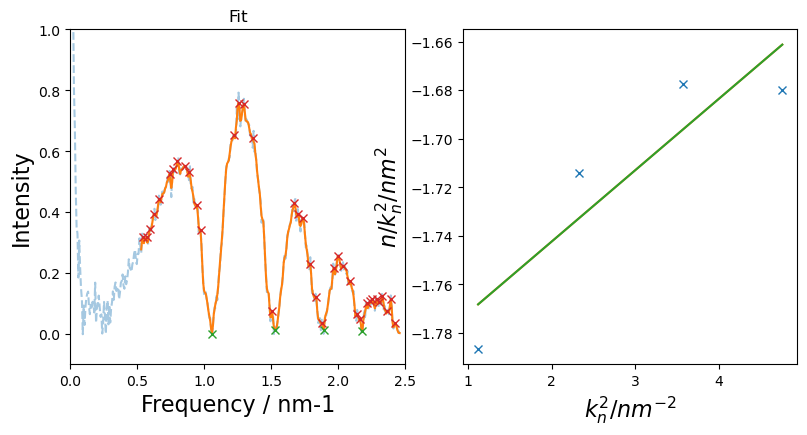

In [108]:
data = genfromtxt('FEG_CTFs\\focus_series_03\\39734.msa', delimiter=',')

# fitting bounds, lower then upper
# range of data to fit
data_bounds=(80, 500) #0, 350

#remove baseline
baseline = baseline_als( data[0:, 1], 100, 0.0001 )
data[0:,1] = data[0:,1]-baseline

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

# smooth ydata
ydata = savgol_filter( ydata, 5, 2, axis=-1, deriv=0, mode='interp')

# find maxima and minima, in nm-1
maxima, minima = find_CTF_zeros( ydata )

#filter badly detected points
minima = np.array([x for x in minima if ydata[x] <= 0.03])
minima = np.array([x for x in minima if xdata[x] <= 2.2e9])

indi_min = np.array( list( range( -2, -len( minima )*2-2, -2 ) ) )
x_min = (xdata[minima])**2
y_min = (indi_min)/(xdata[minima]**2)

indi_max = np.array( list( range( -3, -len( maxima )*2-2, -2 ) ) )
x_max = (xdata[maxima])**2
y_max = (indi_max)/(xdata[maxima]**2)

# fitting
intercept, slope = fit_gradient( x_min, y_min )

Cs_fit = fit_Cs_and_defocus( x_min, y_min, 0.00251 )
#plt.plot(x_min*1e-18, y_min*1e18, "x")

# results
print(Cs_fit.fit_report(show_correl=False))
fig, ax1, ax2 = plotCsFigure( data, xdata, ydata, x_min, y_min, Cs_fit )

ax1.set_xlim([0, 2.5])
ax1.set_ylim([-0.1, 1.0])

ax2.plot( x_min/1e18, gradient_simple(x_min, slope, intercept)*1e18 )

CTF_zeros_39734 = np.stack( [x_min, y_min] )

Text(0.5, 1.0, 'CTF zeros for 2100F')

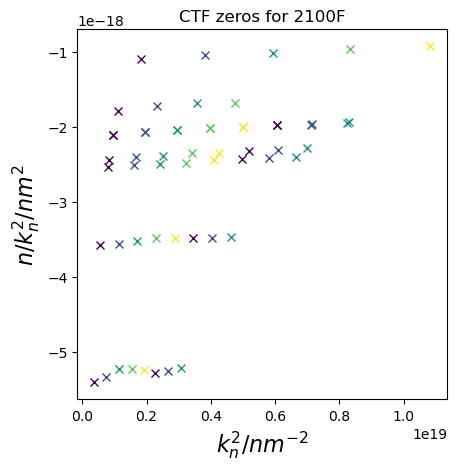

In [220]:
# see Williams and Carter p 506

# stack data somehow, make all arrays same length
#CTF_zeros_stack = np.stack( [CTF_zeros_32133[0, :], CTF_zeros_32135[0, :]])

# find longest list
CTF_list = ( CTF_zeros_32132, CTF_zeros_32133, CTF_zeros_32134, 
             CTF_zeros_32135, CTF_zeros_41042, CTF_zeros_01, CTF_zeros_39735, CTF_zeros_39734 )


CTF_zeros_x = np.zeros((8, 11))
for n in range(len(CTF_list)):
    data = CTF_list[n]
    data = data[0]
    for m in range(len(data)):
        CTF_zeros_x[n, m] = data[m]

CTF_zeros_y = np.zeros((8, 11))
for n in range(len(CTF_list)):
    data = CTF_list[n]
    data = data[1]
    for m in range(len(data)):
        CTF_zeros_y[n, m] = data[m]


CTF_zeros_x[CTF_zeros_x == 0] = np.nan
CTF_zeros_x[CTF_zeros_y == 0] = np.nan

fig, ax = plt.subplots(1)

for n in range(len(CTF_zeros_x)):
    ax.plot( CTF_zeros_x[:, n],CTF_zeros_y[:, n], 'x' )

#ax.plot(CTF_zeros_32133[0, :], CTF_zeros_32133[1, :], "x")
#ax.plot(CTF_zeros_32134[0, :], CTF_zeros_32134[1, :], "x")
#ax.plot(CTF_zeros_32135[0, :], CTF_zeros_32135[1, :], "x")
#ax.plot(CTF_zeros_32132[0, :], CTF_zeros_32132[1, :], "x")
#ax.plot(CTF_zeros_01[0, :], CTF_zeros_01[1, :], "x")
#ax.plot(CTF_zeros_41042[0, :], CTF_zeros_41042[1, :], "x")
#ax.plot(CTF_zeros_39735[0, :], CTF_zeros_39735[1, :], "x")
#ax.plot(CTF_zeros_39734[0, :], CTF_zeros_39734[1, :], "x")

ax.set_ylabel('$n/k_{n}^2 / nm^2$', fontsize = 16)
ax.set_xlabel('$k_{n}^2 / nm^{-2}$', fontsize = 16)
ax.set_box_aspect(1)
ax.set_title('CTF zeros for 2100F')

False
[[Model]]
    Model(CTF)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 151
    # data points      = 150
    # variables        = 4
    chi-square         = 19.8480315
    reduced chi-square = 0.13594542
    Akaike info crit   = -295.379569
    Bayesian info crit = -283.337028
    R-squared          = -9.46772335
[[Variables]]
    lamb:     2.507934e-12 (fixed)
    defocus: -2.2324e-07 +/- 0.03069488 (13749502.80%) (init = -2.28e-07)
    Cs:       0.0014 (fixed)
    C12a:     4.3912e-09 +/- 2.01788835 (45953087054.02%) (init = 0)
    C12b:    -3.7104e-04 +/- 178415.807 (48085637802.58%) (init = 0)
    phi:      5.7986e-06 +/- 1048.27662 (18077965338.51%) (init = 0)
Cs: 1.4 mm
Defocus: -223.24355800671842 nm


array([9.97936942e-01, 9.88067705e-01, 9.69810898e-01, 9.43045109e-01,
       9.07824991e-01, 8.64400356e-01, 8.13230570e-01, 7.54994653e-01,
       6.90595866e-01, 6.21159853e-01, 5.48021646e-01, 4.72723870e-01,
       3.96968387e-01, 3.22597081e-01, 2.51545384e-01, 1.85791422e-01,
       1.27297942e-01, 7.79483228e-02, 3.94784034e-02, 1.34062649e-02,
       9.62513955e-04, 3.02441672e-03, 2.00548164e-02, 5.20525347e-02,
       9.85154570e-02, 1.58418956e-01, 2.30213285e-01, 3.11841882e-01,
       4.00782056e-01, 4.94108722e-01, 5.88580753e-01, 6.80748439e-01,
       7.67083546e-01, 8.44101969e-01, 9.08540237e-01, 9.57489722e-01,
       9.88549922e-01, 9.99965594e-01, 9.90744590e-01, 9.60748779e-01,
       9.10751073e-01, 8.42452665e-01, 7.58456138e-01, 6.62186840e-01,
       5.57793492e-01, 4.49953988e-01, 3.43691967e-01, 2.44138225e-01,
       1.56276131e-01, 8.46788061e-02, 3.32520360e-02, 4.99774871e-03,
       1.81291797e-03, 2.43396780e-02, 7.18691008e-02, 1.42328942e-01,
      

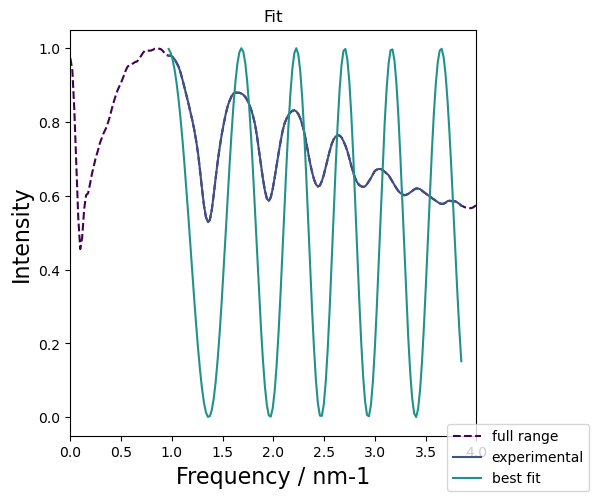

In [170]:
data = genfromtxt('FEG_CTFs\\FEG_CTF_32132_200kV.msa', delimiter=',')

# fitting bounds, lower then upper
# range of data to fit
data_bounds=(50, 200) #0, 350
Cs_bounds = np.array([0.5, 2.0])
defocus_bounds = np.array([-500.0, 0.0])

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

data[0:, 1] = normaliseDataRange( data[0:, 1] )

#Cs in mm, defocus in nm, voltage in kV
fit_CTF( ydata, xdata, fit_defocus=True, fit_Cs=False, voltage=200, Cs=1.4, defocus=-228, Cs_bounds=Cs_bounds, defocus_bounds=defocus_bounds )
# 1.278, -228
### method ###
# fit defocus (have to dial in manually)
# fit Cs
# fit defocus again

False
[[Model]]
    Model(CTF)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 210
    # variables        = 3
    chi-square         = 24.6073698
    reduced chi-square = 0.11887618
    Akaike info crit   = -444.252925
    Bayesian info crit = -434.211602
    R-squared          = -29.3311172
##  Warning: uncertainties could not be estimated:
[[Variables]]
    lamb:     2.507934e-12 (fixed)
    defocus: -4.1e-07 (fixed)
    Cs:       0.0014 (fixed)
    C12a:     0.00000000 (init = 0)
    C12b:     0.00000000 (init = 0)
    phi:      0.00000000 (init = 0)
Cs: 1.4 mm
Defocus: -410.00000000000006 nm


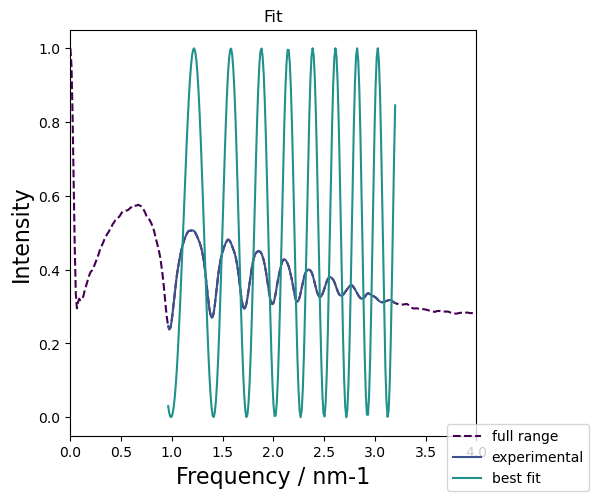

In [49]:
data = genfromtxt('FEG_CTFs\\FEG_CTF_32133_200kV.msa', delimiter=',')
# fitting bounds, lower then upper
# range of data to fit
data_bounds=(90, 300) #0, 350
Cs_bounds = np.array([0.5, 2.0])
defocus_bounds = np.array([-500.0, 0.0])

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

data[0:, 1] = normaliseDataRange( data[0:, 1] )

#xdata = data[0:,0]*1e9
#ydata = data[0:,1]

#Cs in mm, defocus in nm, voltage in kV
results = fit_CTF( ydata, xdata, fit_defocus=False, fit_Cs=False, voltage=200, 
         Cs=1.4, defocus=-410, Cs_bounds=Cs_bounds, defocus_bounds=defocus_bounds )

0.4618511932739737


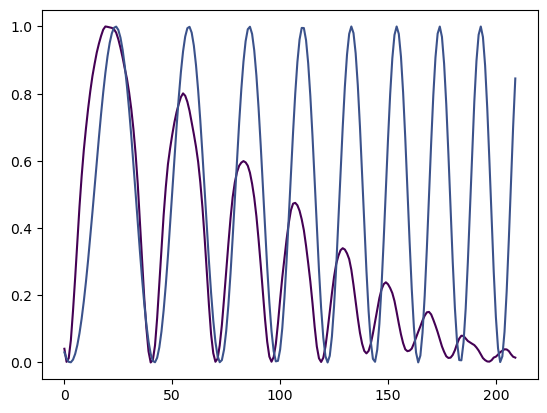

In [50]:
signal1 = ydata
signal2 = results

#damp signal 2

baseline = baseline_als( signal1, 100, 0.0001 )
signal1=signal1-baseline

signal1 = normaliseDataRange( signal1 )

numpy_correlation = np.corrcoef(signal1, signal2)[0, 1]
print(numpy_correlation)

plt.plot(signal1)
plt.plot(signal2)

False
[[Model]]
    Model(CTF)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 526
    # data points      = 210
    # variables        = 4
    chi-square         = 24.1872397
    reduced chi-square = 0.11741378
    Akaike info crit   = -445.869288
    Bayesian info crit = -432.480858
    R-squared          = -28.5856200
[[Variables]]
    lamb:     2.507934e-12 (fixed)
    defocus: -4.0682e-07 +/- 3.2193e-06 (791.35%) (init = -4.23e-07)
    Cs:       0.0014 (fixed)
    C12a:    -6.5078e-09 +/- 3.2643e-06 (50159.67%) (init = 0)
    C12b:    -2.8642e-07 +/- 5.1047e+14 (178222292546123439538176.00%) (init = 0)
    phi:     -4.3137e-09 +/- 7.6879e+12 (178222292547937794785280.00%) (init = 0)
Cs: 1.4 mm
Defocus: -406.81837850654597 nm


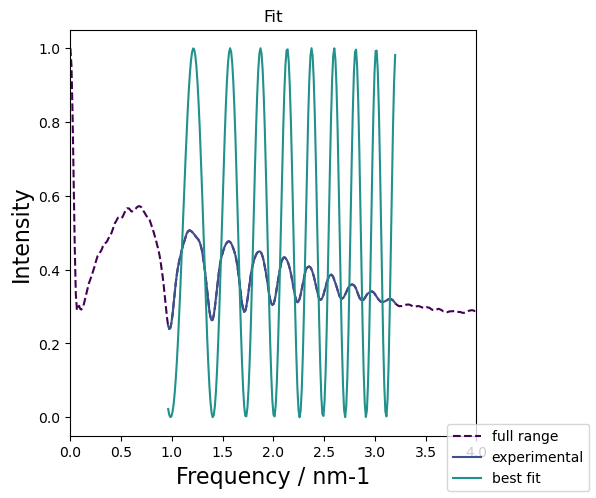

In [51]:
data = genfromtxt('FEG_CTFs\\FEG_CTF_32134_200kV.msa', delimiter=',')
# fitting bounds, lower then upper
# range of data to fit
data_bounds=(90, 300) #0, 350
Cs_bounds = np.array([0.5, 2.0])
defocus_bounds = np.array([-500.0, 0.0])

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

data[0:, 1] = normaliseDataRange( data[0:, 1] )

#xdata = data[0:,0]*1e9
#ydata = data[0:,1]

#Cs in mm, defocus in nm, voltage in kV
fit_CTF( ydata, xdata, fit_defocus=True, fit_Cs=False, voltage=200, Cs=1.4, defocus=-423, Cs_bounds=Cs_bounds, defocus_bounds=defocus_bounds )

False
[[Model]]
    Model(CTF)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 133
    # data points      = 230
    # variables        = 4
    chi-square         = 23.3810524
    reduced chi-square = 0.10345598
    Akaike info crit   = -517.815268
    Bayesian info crit = -504.062951
    R-squared          = -18.1297964
[[Variables]]
    lamb:     2.507934e-12 (fixed)
    defocus: -4.9411e-07 +/- 0.03542805 (7170074.27%) (init = -5.08e-07)
    Cs:       0.0014 (fixed)
    C12a:     3.5134e-09 +/- 0.97836054 (27846155026.69%) (init = 0)
    C12b:    -5.4706e-04 +/- 46210.3696 (8446961857.17%) (init = 0)
    phi:      1.1260e-05 +/- 658.253538 (5845733266.63%) (init = 0)
Cs: 1.4 mm
Defocus: -494.10993400637824 nm


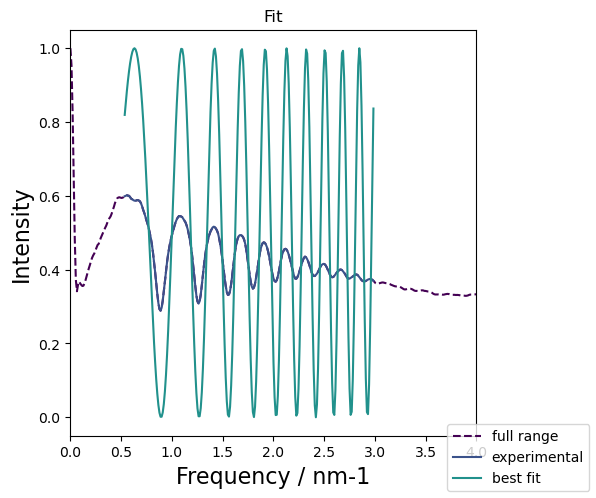

In [60]:
data = genfromtxt('FEG_CTFs\\FEG_CTF_32135_200kV.msa', delimiter=',')
# fitting bounds, lower then upper
# range of data to fit
data_bounds=(50, 280) #0, 350
Cs_bounds = np.array([0.5, 2.0])
defocus_bounds = np.array([-500.0, 0.0])

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

data[0:, 1] = normaliseDataRange( data[0:, 1] )

#xdata = data[0:,0]*1e9
#ydata = data[0:,1]

#Cs in mm, defocus in nm, voltage in kV
fit_CTF( ydata, xdata, fit_defocus=True, fit_Cs=False, voltage=200, Cs=1.4, defocus=-508, Cs_bounds=Cs_bounds, defocus_bounds=defocus_bounds )

False
[[Model]]
    Model(CTF)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 222
    # data points      = 200
    # variables        = 4
    chi-square         = 57.5611295
    reduced chi-square = 0.29367923
    Akaike info crit   = -241.093972
    Bayesian info crit = -227.900703
    R-squared          = -247.565265
[[Variables]]
    lamb:     2.507934e-12 (fixed)
    defocus: -7.1984e-07 +/- 0.24327789 (33796009.12%) (init = -7e-07)
    Cs:       0.0014 (fixed)
    C12a:     1.2281e-06 +/- 0.09234053 (7519152.25%) (init = 0)
    C12b:     9.7175e-07 +/- 339.175662 (34903550253.20%) (init = 0)
    phi:     -0.00506581 +/- 1822179.40 (35970181094.22%) (init = 0)
Cs: 1.4 mm
Defocus: -719.842074630586 nm


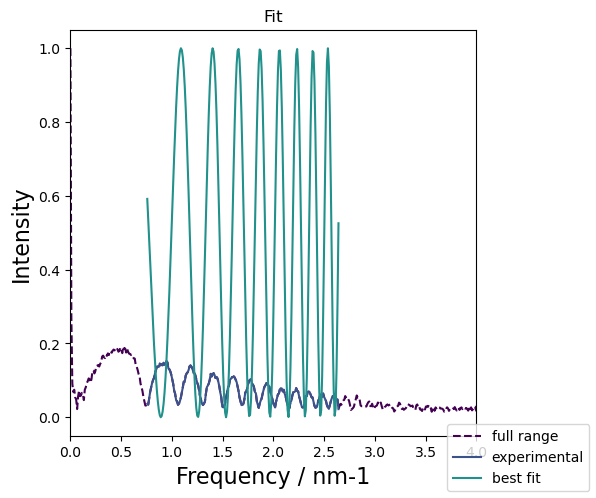

In [65]:
data = genfromtxt('FEG_Cc\\01_CTF.msa', delimiter=',')
# fitting bounds, lower then upper
# range of data to fit
data_bounds=(80, 280) #0, 350
Cs_bounds = np.array([0.5, 2.0])
defocus_bounds = np.array([-500.0, 0.0])

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

data[0:, 1] = normaliseDataRange( data[0:, 1] )

#xdata = data[0:,0]*1e9
#ydata = data[0:,1]

#Cs in mm, defocus in nm, voltage in kV
fit_CTF( ydata, xdata, fit_defocus=True, fit_Cs=False, voltage=200, Cs=1.4, defocus=-700, Cs_bounds=Cs_bounds, defocus_bounds=defocus_bounds )

[[Model]]
    Model(gradient_CTF)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 9
    # variables        = 2
    chi-square         = 5.4756e-40
    reduced chi-square = 7.8223e-41
    Akaike info crit   = -829.402865
    Bayesian info crit = -829.008416
    R-squared          = 1.00000000
[[Variables]]
    Cs:       0.00139319 +/- 6.8268e-05 (4.90%) (init = 0.0015)
    defocus:  4.2132e-07 +/- 1.2391e-09 (0.29%) (init = -4e-07)
    lamb:     2.51e-12 (fixed)
Cs: 1.3931879950141426 mm
Defocus: 421.3226204040006 nm


Text(0.5, 23.52222222222222, '$k_{n}^2 / nm^{-2}$')

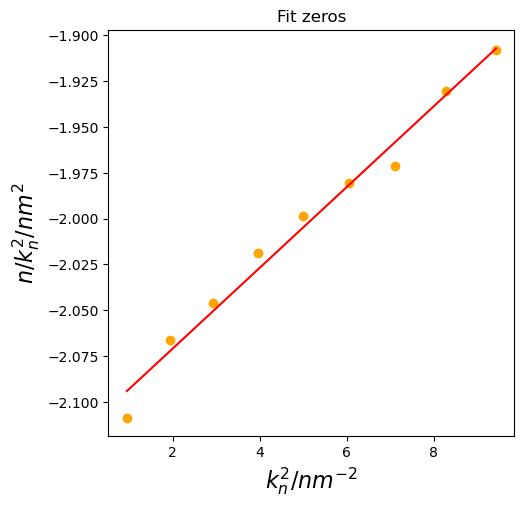

In [245]:
# zeros but with lmfit
def gradient_CTF(x, Cs, defocus, lamb):
    y = Cs*(lamb**3)*x - 2*lamb*defocus
    return y

model = mdl(gradient_CTF)
params = model.make_params( defocus=-400e-9, Cs=1.5e-3, lamb=0.00251e-9 )
#print(f'independent variables: {model.independent_vars}')
params['Cs'].vary = True
params['Cs'].min = 1.0e-3
params['Cs'].max = 2.0e-3
params['defocus'].vary = True
params['lamb'].vary = False
# do fitting
results = model.fit(y_min, params, x=x_min )
# fit results
print(results.fit_report(show_correl=False))
print( 'Cs: ' + str( results.params['Cs'].value * 1e3 ) + ' mm' )
print( 'Defocus: ' + str( results.params['defocus'].value * 1e9 ) + ' nm' )
# figure
fig, ax  = plt.subplots(1,1)
ax.scatter(x_min/1e18, y_min*1e18, color='orange')
ax.plot(x_min/1e18, results.best_fit*1e18, label='best fit', color='red')
ax.set_box_aspect(1)
ax.set_title("Fit zeros")
fig.tight_layout()
ax.set_ylabel('$n/k_{n}^2 / nm^2$', fontsize = 16)
ax.set_xlabel('$k_{n}^2 / nm^{-2}$', fontsize = 16)

In [ ]:
# data = genfromtxt('FEG_CTFs\\FEG_CTF_32134_200kV.msa', delimiter=',')
# fitting bounds, lower then upper
# range of data to fit
data_bounds=(90, 300) #0, 350
Cs_bounds = np.array([0.5, 2.0])
defocus_bounds = np.array([-500.0, 0.0])

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

data[0:, 1] = normaliseDataRange( data[0:, 1] )

#xdata = data[0:,0]*1e9
#ydata = data[0:,1]

#Cs in mm, defocus in nm, voltage in kV
fit_CTF( ydata, xdata, fit_defocus=False, fit_Cs=False, voltage=200, Cs=1.278, defocus=-421, Cs_bounds=Cs_bounds, defocus_bounds=defocus_bounds )

[[Model]]
    Model(gradient_CTF)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 9
    # variables        = 2
    chi-square         = 1.1750e-39
    reduced chi-square = 1.6785e-40
    Akaike info crit   = -822.531118
    Bayesian info crit = -822.136669
    R-squared          = 1.00000000
[[Variables]]
    Cs:       0.00119734 +/- 1.0064e-04 (8.41%) (init = 0.0015)
    defocus:  4.2086e-07 +/- 1.9581e-09 (0.47%) (init = -4e-07)
    lamb:     2.51e-12 (fixed)
Cs: 1.1973396055091483 mm
Defocus: 420.8570856321985 nm


Text(0.5, 23.52222222222222, '$k_{n}^2 / nm^{-2}$')

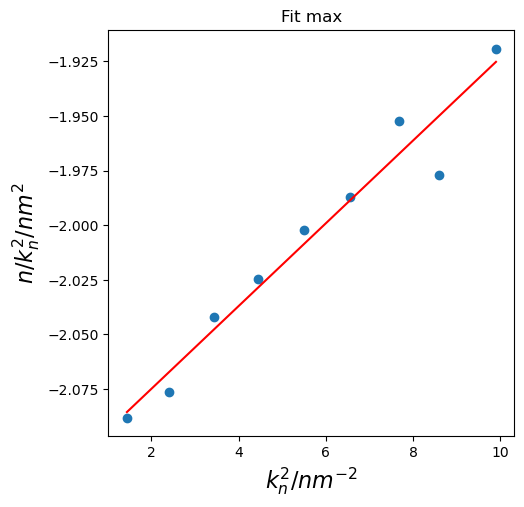

In [244]:
# fit max
indi_max = [-3, -5, -7, -9, -11, -13, -15, -17, -19]
x_max = (xdata[maxima])**2
y_max = (indi_max)/(xdata[maxima]**2)

model = mdl(gradient_CTF)
params = model.make_params( defocus=-400e-9, Cs=1.5e-3, lamb=0.00251e-9 )
params['Cs'].vary = True
params['Cs'].min = 1.0e-3
params['Cs'].max = 2.0e-3
params['defocus'].vary = True
params['lamb'].vary = False
# do fitting
results = model.fit(y_max, params, x=x_max )
# fit results
print(results.fit_report(show_correl=False))
print( 'Cs: ' + str( results.params['Cs'].value * 1e3 ) + ' mm' )
print( 'Defocus: ' + str( results.params['defocus'].value * 1e9 ) + ' nm' )
# figure
fig, ax  = plt.subplots(1,1)
ax.scatter(x_max/1e18, y_max*1e18)
ax.plot(x_max/1e18, results.best_fit*1e18, label='best fit', color='red')
ax.set_box_aspect(1)
ax.set_title("Fit max")
fig.tight_layout()
ax.set_ylabel('$n/k_{n}^2 / nm^2$', fontsize = 16)
ax.set_xlabel('$k_{n}^2 / nm^{-2}$', fontsize = 16)

[  1  40  70  96 119 140 159 179 197  22  55  83 107 129 149 169 184 204]
[[Model]]
    Model(gradient_CTF)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 18
    # variables        = 2
    chi-square         = 2.9324e-39
    reduced chi-square = 1.8327e-40
    Akaike info crit   = -1645.07688
    Bayesian info crit = -1643.29613
    R-squared          = 1.00000000
[[Variables]]
    Cs:       0.00128170 +/- 7.3844e-05 (5.76%) (init = 0.0015)
    defocus:  4.2094e-07 +/- 1.3894e-09 (0.33%) (init = -4e-07)
    lamb:     2.51e-12 (fixed)
Cs: 1.2817006452422188 mm
Defocus: 420.9361344921454 nm


Text(0.5, 23.52222222222222, '$k_{n}^2 / nm^{-2}$')

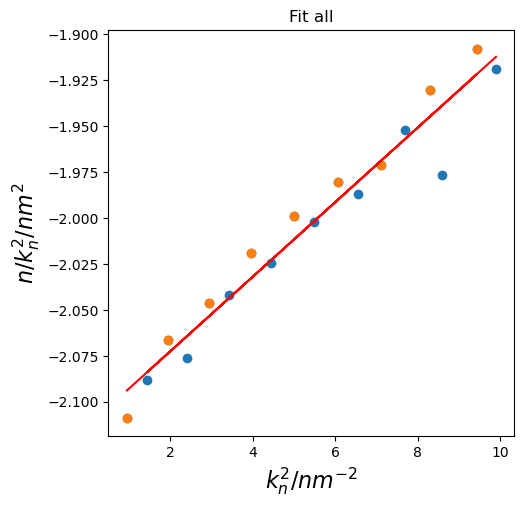

In [243]:
# all peaks
maximin = np.concatenate( (minima, maxima) )
print(maximin)
indi = [-2, -4, -6, -8, -10, -12, -14, -16, -18, -3, -5, -7, -9, -11, -13, -15, -17, -19]

x_all = (xdata[maximin])**2
y_all = (indi)/(xdata[maximin]**2)

model = mdl(gradient_CTF)
params = model.make_params( defocus=-400e-9, Cs=1.5e-3, lamb=0.00251e-9 )
params['Cs'].vary = True
params['Cs'].min = 1.0e-3
params['Cs'].max = 2.0e-3
params['defocus'].vary = True
params['lamb'].vary = False
# do fitting
results = model.fit(y_all, params, x=x_all )
# fit results
print(results.fit_report(show_correl=False))
print( 'Cs: ' + str( results.params['Cs'].value * 1e3 ) + ' mm' )
print( 'Defocus: ' + str( results.params['defocus'].value * 1e9 ) + ' nm' )
# figure
fig, ax  = plt.subplots(1,1)
ax.scatter(x_all/1e18, y_all*1e18)
ax.scatter(x_min/1e18, y_min*1e18)
ax.plot(x_all/1e18, results.best_fit*1e18, label='best fit', color='red')
ax.set_box_aspect(1)
ax.set_title("Fit all")
fig.tight_layout()
ax.set_ylabel('$n/k_{n}^2 / nm^2$', fontsize = 16)
ax.set_xlabel('$k_{n}^2 / nm^{-2}$', fontsize = 16)


False
[[Model]]
    Model(CTF)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 210
    # variables        = 4
    chi-square         = 23.5169962
    reduced chi-square = 0.11416018
    Akaike info crit   = -451.770667
    Bayesian info crit = -438.382237
    R-squared          = -38.8182110
##  Warning: uncertainties could not be estimated:
    defocus:  at initial value
[[Variables]]
    lamb:     2.507934e-12 (fixed)
    defocus: -5.0500e-07 (init = -5.05e-07)
    Cs:       0.001278 (fixed)
    C12a:     0.00000000 (init = 0)
    C12b:     0.00000000 (init = 0)
    phi:      0.00000000 (init = 0)
Cs: 1.278 mm
Defocus: -505.00000000000006 nm


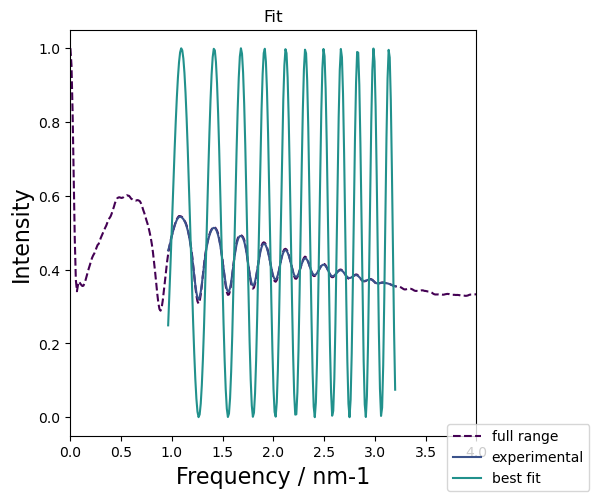

In [13]:
data = genfromtxt('FEG_CTFs\\FEG_CTF_32135_200kV.msa', delimiter=',')
# fitting bounds, lower then upper
# range of data to fit
data_bounds=(90, 300) #0, 350
Cs_bounds = np.array([0.5, 2.0])
defocus_bounds = np.array([-500.0, 0.0])

data[0:, 1] = normaliseDataRange( data[0:, 1] )

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]

# smooth the y data with savitsky-golay
from scipy.signal import savgol_filter
ydata = savgol_filter( ydata, 5, 1, axis=-1, deriv=0, mode='nearest')

#xdata = data[0:,0]*1e9
#ydata = data[0:,1]

#Cs in mm, defocus in nm, voltage in kV
fit_CTF( ydata, xdata, fit_defocus=True, fit_Cs=False, voltage=200, Cs=1.278, defocus=-505, Cs_bounds=Cs_bounds, defocus_bounds=defocus_bounds )

In [3]:
# 2D CTF
# define variables
def create2DCTF( lamb, flim, **kwargs ):
    image_size = kwargs.get('size', int(128) )
    defocus = kwargs.get('defocus', 0)
    focal_spread = kwargs.get('focal_spread', 5.25)
    Cs = kwargs.get('Cs', (1.6/1000))
    Cc = kwargs.get('Cc', (1.6/1000))
    beta = kwargs.get('beta', 0 )
    cutoff = kwargs.get('cutoff', flim )
    # arrays to hold 2d data
    imageX = imageY = image_size  
    radius = imageX/2
    CTF2d = np.ones((imageX,imageY))
    irow, icol = np.indices(CTF2d.shape)
    centX = irow - CTF2d.shape[0] / 2.0
    centY = icol - CTF2d.shape[1] / 2.0
    #distance from centre
    iradius = (centX**2 + centY**2)**0.5
    #angle from centre
    itheta = np.arctan2(centX, centY)
    # distance per pixel
    scale = image_size / flim
    # scale iradius to spatial frequncy
    iradius = iradius / scale # check that distance units are set right here
    ## 2D CTF ##
    CTF2d = np.sin( (np.pi*defocus*lamb*(iradius**2) ) + (0.5*np.pi*Cs*(lamb**3)*(iradius**4)) )
    ## Damping functions ##
    # Aperture function
    Aperture2d = create2DAperture( imageX, imageY, cutoff, iradius )
    # Temporal coherence
    Et2d = create2DTemporal( Cc, focal_spread, kV, iradius )
    # Spatial coherence
    Es2d = creat2DSpatial( lamb, iradius, defocus, Cs )
    ## damped and square CTF ##
    damped = ( CTF2d * Es2d * Et2d * Aperture2d )
    squared = damped * damped
    print(defocus)
    return CTF2d, squared

def create2DTemporal( Cc, focal_spread, kV, iradius ):
    delta = Cc * (focal_spread / (kV * 1000))
    Et2d = np.exp( -0.25*(( np.pi* lamb * delta)**2) * (iradius**4) )
    return Et2d
    
    # Spatial coherence
def creat2DSpatial( lamb, iradius, defocus, Cs ):
    #derivative of CTF
    dChi_2d = (2*np.pi*lamb*iradius*defocus) + (2*np.pi*Cs*(lamb**3)*(iradius**3))# really small numbers for some reason
    Es2d = np.exp( -(beta / ((4*lamb**2))) * abs(dChi_2d)**2 )
    return Es2d
    
def create2DAperture( imageX, imageY, cutoff, iradius ):
    # Aperture function
    Aperture2d = np.ones((imageX,imageY))
    n = range(0, len(Aperture2d[0] ))
    m = range(0, len(Aperture2d[1] ))
    for i in n:
        for j in m:
            if iradius[i,j] < cutoff:
                Aperture2d[i,j] = 1
            if iradius[i,j] >= cutoff:
                Aperture2d[i,j] = 0
    return Aperture2d

Cs: 1.6 mm
Defocus: -100.0 nm
C12a: 50.0 nm


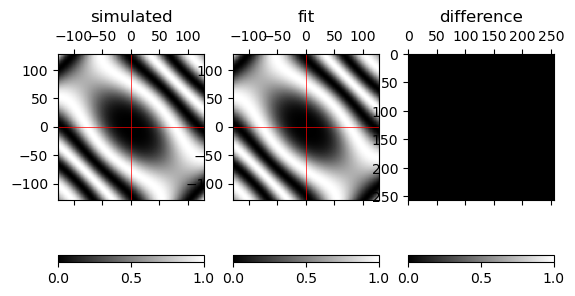

In [314]:
# 2d fit with lmfit of simulated 2D CTF
# full CTF expansion to inlcude astigmatism

# 2D CTF
# define variables
def create2DCTF( lamb, flim, **kwargs ):
    image_size = kwargs.get('size', int(128) )
    defocus = kwargs.get('defocus', 0)
    Cs = kwargs.get('Cs', (1.6/1000))
    Cc = kwargs.get('Cc', (1.6/1000))
    C12a = kwargs.get('C12a', 0 )
    C12b = kwargs.get('C12b', 0 )
    # arrays to hold 2d data
    imageX = imageY = image_size  
    radius = imageX/2
    CTF2d = np.ones((imageX,imageY))
    irow, icol = np.indices(CTF2d.shape)
    centX = irow - CTF2d.shape[0] / 2.0
    centY = icol - CTF2d.shape[1] / 2.0
    #distance from centre
    iradius = (centX**2 + centY**2)**0.5
    #angle from centre
    itheta = np.arctan2(centX, centY)
    # distance per pixel
    scale = image_size / flim
    # scale iradius to spatial frequncy
    iradius = iradius / scale # check that distance units are set right here
    ## 2D CTF ##
    CTF2d = np.sin( np.pi*lamb*(iradius**2)*(defocus + C12a*np.sin(2*itheta) + C12b*np.cos(2*itheta)) + (0.5*np.pi*Cs*(lamb**3)*(iradius**4)) )**2
    return CTF2d, iradius, itheta

def modelCTF2D( g, phi, lamb, defocus, Cs, C12a, C12b ):
    #g = np.sqrt(np.square(x) + np.square(y))
    #phi = np.atan2(x, y)
    func = np.sin( (np.pi*lamb*(g**2))*(defocus + C12a*np.sin(2*phi) + C12b*np.cos(2*phi))  +(0.5*np.pi*Cs*(lamb**3)*(g**4)))**2
    return func


CTF_2D, iradius, itheta = create2DCTF( 0.00251e-9, 5e9, defocus=(-100e-9), size=int(256), C12a=50e-9 )
scaleDataRange(CTF_2D)

model2d = mdl( modelCTF2D, independent_vars=['g', 'phi'] )
params = model2d.make_params(   )
params['defocus'].set(value=-100e-9, min=-250e-9, max=-50e-9)
params['Cs'].set(value=1.6e-3, min=1.0e-3, max=2.0e-3)
params['lamb'].set(value=0.00251e-9)
params['Cs'].vary = False
params['lamb'].vary = False
params['C12a'].set(value=50e-9, min=0, max=60e-9)#, min=49e-9, max=50e-9)
params['C12a'].vary = True
params['C12b'].set(value=0)
params['C12b'].vary = False
params['defocus'].vary = False

# do fitting
results_2d = model2d.fit(CTF_2D, params, g=iradius, phi=itheta )

print( 'Cs: ' + str( results_2d.params['Cs'].value * 1e3 ) + ' mm' )
print( 'Defocus: ' + str( results_2d.params['defocus'].value * 1e9 ) + ' nm' )
print( 'C12a: ' + str( results_2d.params['C12a'].value * 1e9 ) + ' nm' )

fig, axs = plt.subplots(1, 3)
fit = model2d.func( g=iradius, phi=itheta, **results_2d.best_values )
axs[1].matshow( fit, cmap='grey', extent=[-fit.shape[1]/2., fit.shape[1]/2., -fit.shape[0]/2., fit.shape[0]/2. ])
axs[1].set_title('fit')
axs[1].axhline(0, color='red', linewidth=0.5)
axs[1].axvline(0, color='red', linewidth=0.5)

axs[0].matshow(CTF_2D, cmap='grey', extent=[-CTF_2D.shape[1]/2., CTF_2D.shape[1]/2., -CTF_2D.shape[0]/2., CTF_2D.shape[0]/2. ])
axs[0].set_title('simulated')
axs[0].axhline(0, color='red', linewidth=0.5)
axs[0].axvline(0, color='red', linewidth=0.5)

axs[2].matshow( (CTF_2D - fit), cmap='grey' )
axs[2].set_title('difference')

#axs[3].matshow(itheta, cmap='grey')

#colourbar
from matplotlib import cm
cmap = plt.colormaps['grey']
fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=axs[0], orientation='horizontal')
fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=axs[1], orientation='horizontal')
fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=axs[2], orientation='horizontal')

In [165]:
def plot2Dfit(data, fit, scale):
    fig, ax = plt.subplots(1, 1)
    # side-by-side plot
    sbs = data
    limit=int(np.size(data,0)/2)
    #sbs[limit:,limit:] = fit[limit:,limit:]
    sbs[limit:,limit:] = fit[limit:,limit:]
    ax.imshow( sbs, cmap='grey',  extent=[-data.shape[1]/2., data.shape[1]/2., -data.shape[0]/2., data.shape[0]/2. ])
    #ax.axvline(0, 0, color='r')
    #ax.axhline(0, 0, color='r')
    ax.set_xticks([])
    ax.set_yticks([])
    from matplotlib import cm
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(cm.ScalarMappable(cmap='grey'), cax=cax )
    from mpl_toolkits.axes_grid1.anchored_artists import (AnchoredSizeBar)
    scalebar = AnchoredSizeBar(ax.transData, 1/scale, '1 nm$^{-1}$', loc='lower left', frameon=True, size_vertical=2, borderpad=0.2)
    ax.add_artist(scalebar)
    return

def plot2Dfitalt(data, fit, scale):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # side-by-side plot
    ax1.imshow( data, cmap='grey')
    ax2.imshow( fit, cmap='grey')
    return

def modelCTF2D( g, phi, lamb, defocus, Cs, C12a, C12b ):
    func = np.sin( (np.pi*lamb*(g**2))*(defocus + C12a*np.sin(2*phi)
                                        + C12b*np.cos(2*phi))  +(0.5*np.pi*Cs*(lamb**3)*(g**4)))**2
    return func

def fit2DCTF( data, scale, **kwargs ):
    # scale in nm-1
    # kwargs
    fit_defocus = kwargs.get('fit_defocus', True)
    fit_Cs = kwargs.get('fit_Cs', False)
    fit_C2astig = kwargs.get('fit_C21', [False, False])
    defocus_val = kwargs.get('defocus', 0) * 1e-9
    Cs_val = kwargs.get('Cs', 1.6) *1e-3
    C21_val = kwargs.get('C21', [0.0, 0.0])
    defocus_bounds = kwargs.get('defocus_bounds', [-np.inf, np.inf])
    C2astig_bounds = kwargs.get('C21_bounds', [-np.inf, np.inf,-np.inf, np.inf])
    Cs_bounds = kwargs.get('Cs_bounds', [-np.inf, np.inf])
    # convert to SI units
    data = scaleDataRange( data )
    # x and y data for fitting function
    imageX = np.size(data,0)
    irow, icol = np.indices(data.shape)
    centX = irow - data.shape[0] / 2.0
    centY = icol - data.shape[1] / 2.0
    iradius = ((centX**2 + centY**2)**0.5) * scale * 1e9
    itheta = np.arctan2(centX, centY)
    # make model and init values
    model2d = mdl( modelCTF2D, independent_vars=['g', 'phi'] )
    params = model2d.make_params()
    params['defocus'].vary = fit_defocus
    params['defocus'].set(value=defocus_val, min=defocus_bounds[0]*1e-9, max=defocus_bounds[1]*1e-9)
    params['lamb'].set(value=0.00251e-9)
    params['lamb'].vary = False
    params['Cs'].vary = fit_Cs
    params['Cs'].set(value=Cs_val, min=Cs_bounds[0]*1e-3, max=Cs_bounds[1]*1e-3)
    params['C12a'].set(value=C21_val[0]*1e-9, min=C2astig_bounds[0]*1e-9, max=C2astig_bounds[1]*1e-9)
    params['C12a'].vary = fit_C2astig[0]
    params['C12b'].set(value=C21_val[1]*1e-9, min=C2astig_bounds[2]*1e-9, max=C2astig_bounds[3]*1e-9)
    params['C12b'].vary = fit_C2astig[1]
    # do fitting
    results_2d = model2d.fit(data, params, g=iradius, phi=itheta )
    # report the fit results
    printAberrations( results_2d )
    # plot figure
    fit = model2d.func( g=iradius, phi=itheta, **results_2d.best_values )
    plot2Dfit( data, fit, scale )
    return
    
def printAberrations( result ):
    print( 'Cs: ' + str( result.params['Cs'].value * 1e3 ) + ' mm' )
    print( 'Defocus: ' + str( result.params['defocus'].value * 1e9 ) + ' nm' )
    print( 'C12a: ' + str( result.params['C12a'].value * 1e9 ) + ' nm' )
    print( 'C12b: ' + str( result.params['C12b'].value * 1e9 ) + ' nm' )
    return

def importImageFromFile( input_image ):
    from skimage.io import imread
    return imread( input_image )
    

Cs: 1.6 mm
Defocus: -226.18272256492335 nm
C12a: 0.0492152810886291 nm
C12b: 1.1921980189905157 nm


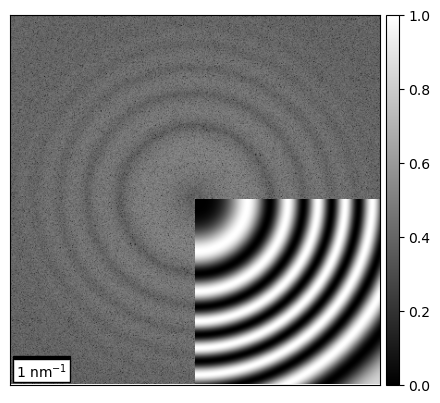

In [9]:
CTF = importImageFromFile( 'FEG_CTFs\\FEG_CTF_test.tif' )
fit2DCTF( CTF, 0.016843, defocus=-226, fit_defocus=True, defocus_bounds=[-230,-220], fit_C2=True, fit_Cs=False )

Cs: 1.6 mm
Defocus: -1055.6178242706155 nm
C12a: 0.0 nm
C12b: 0.0 nm


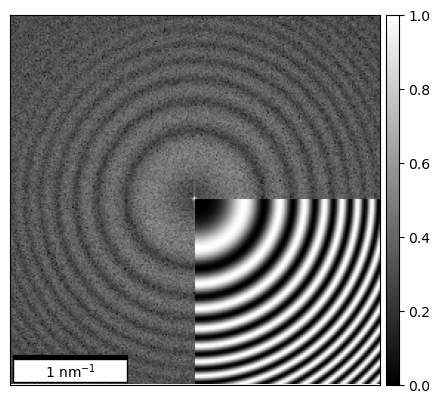

In [14]:
CTF = importImageFromFile( 'FEG_CTFs\\focus_series\\04.tif' )
fit2DCTF( CTF, 0.013225, defocus=-1055, fit_defocus=True, defocus_bounds=[-1100,-1000], 
          fit_C2=False, fit_Cs=False)

Cs: 1.6 mm
Defocus: -352.24 nm
C12a: 0.0 nm
C12b: 0.0 nm


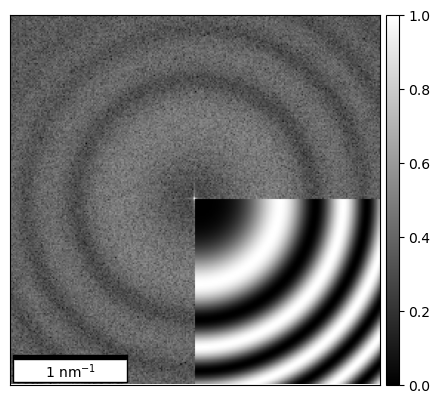

In [31]:
CTF = importImageFromFile( 'FEG_CTFs\\focus_series\\03.tif' )
fit2DCTF( CTF, 0.013225, defocus=-352.24, fit_defocus=False, defocus_bounds=[-400,-200], 
          fit_C2=True, fit_Cs=False)

Cs: 1.6 mm
Defocus: -288.38 nm
C12a: 0.0 nm
C12b: 0.0 nm


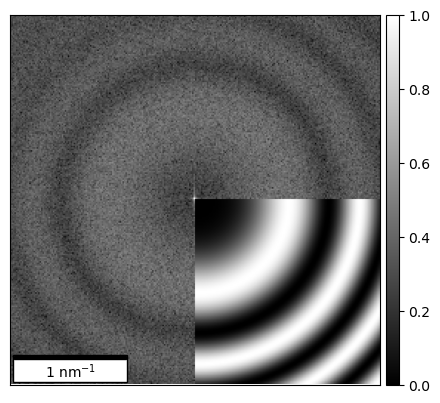

In [29]:
CTF = importImageFromFile( 'FEG_CTFs\\focus_series\\02.tif' )
fit2DCTF( CTF, 0.013225, defocus=-288.38, fit_defocus=False, defocus_bounds=[-300,-100], 
          fit_C2=True, fit_Cs=False)

Cs: 1.6 mm
Defocus: -215.61680932416138 nm
C12a: 0.0 nm
C12b: 0.0 nm


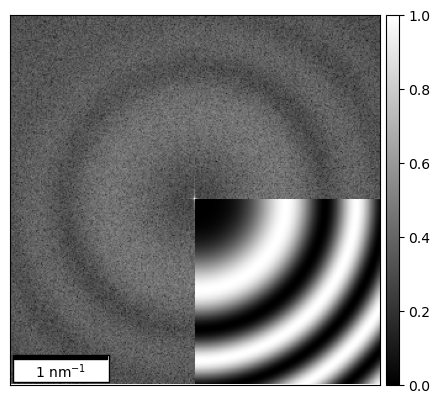

In [41]:
CTF = importImageFromFile( 'FEG_CTFs\\focus_series\\01b.tif' )
fit2DCTF( CTF, 0.013225, defocus=-215, fit_defocus=True, defocus_bounds=[-220,-210], 
          fit_C2=False, fit_Cs=False)

Cs: 1.6 mm
Defocus: -161.6 nm
C12a: 0.0 nm
C12b: 0.0 nm


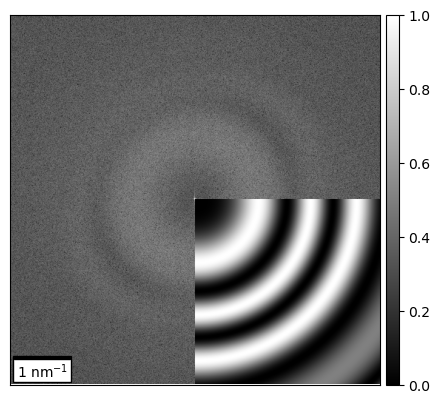

In [60]:
CTF = importImageFromFile( 'FEG_CTFs\\focus_series\\00b.tif' )
fit2DCTF( CTF, 0.013225, defocus=-161.6, fit_defocus=False, defocus_bounds=[-200,-100], 
          fit_C2=True, fit_Cs=False)

Cs: 1.6 mm
Defocus: -405.8737047325763 nm
C12a: 0.0 nm
C12b: 0.0 nm


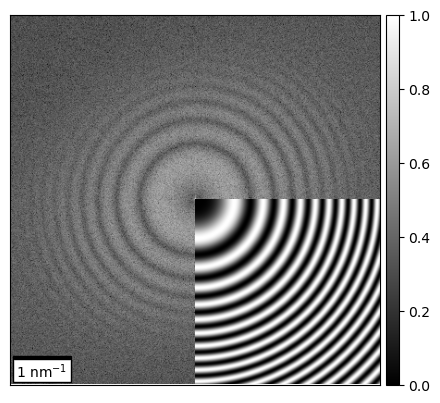

In [117]:
CTF = importImageFromFile( 'FEG_CTFs\\focus_series_02\\04.tif' )#0.016683 0.033365
fit2DCTF( CTF, 0.016683, defocus=-400, fit_defocus=True, defocus_bounds=[-410,-395], 
          fit_C2=False, fit_Cs=False)

Cs: 1.6 mm
Defocus: -331.8928841783176 nm
C12a: 0.0 nm
C12b: 0.0 nm


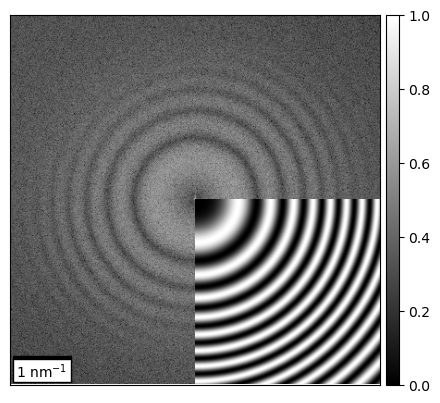

In [84]:
CTF = importImageFromFile( 'FEG_CTFs\\focus_series_02\\03.tif' )#0.016683 0.033365
fit2DCTF( CTF, 0.016683, defocus=-320, fit_defocus=True, defocus_bounds=[-340,-320], 
          fit_C2=False, fit_Cs=False)

Cs: 1.6 mm
Defocus: -244.83896021303684 nm
C12a: 0.0 nm
C12b: 0.0 nm


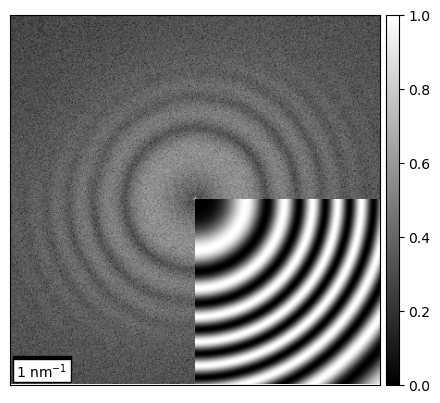

In [101]:
CTF = importImageFromFile( 'FEG_CTFs\\focus_series_02\\02.tif' )#0.016683 0.033365
fit2DCTF( CTF, 0.016683, defocus=-260, fit_defocus=True, defocus_bounds=[-260,-240], 
          fit_C2=False, fit_Cs=False)

Cs: 1.6 mm
Defocus: -184.87890700817832 nm
C12a: 0.0 nm
C12b: 0.0 nm


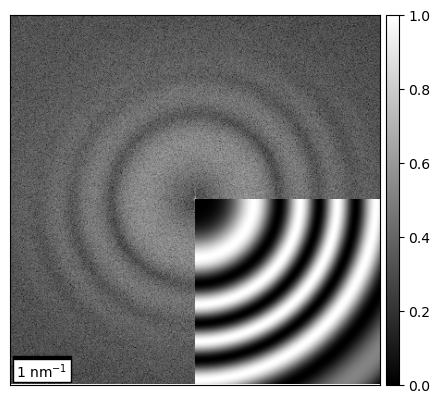

In [100]:
CTF = importImageFromFile( 'FEG_CTFs\\focus_series_02\\01.tif' )#0.016683 0.033365
fit2DCTF( CTF, 0.016683, defocus=-200, fit_defocus=True, defocus_bounds=[-200,-180], 
          fit_C2=False, fit_Cs=False)

Cs: 1.6 mm
Defocus: -112.00000000000001 nm
C12a: 0.0 nm
C12b: 0.0 nm


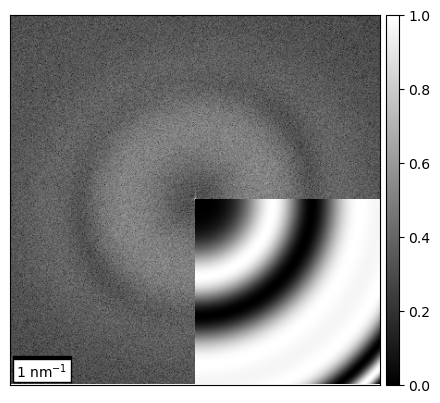

In [116]:
CTF = importImageFromFile( 'FEG_CTFs\\focus_series_02\\00.tif' )#0.016683 0.033365
fit2DCTF( CTF, 0.016683, defocus=-112, fit_defocus=False, defocus_bounds=[-115,-110], 
          fit_C2=False, fit_Cs=False)
# doesn't fit the ones close to focus very well as not much left to fit

Cs: 1.6 mm
Defocus: -340.51155265859416 nm
C12: 45.36600000000001 nm
C12 angle: 0.84 rad


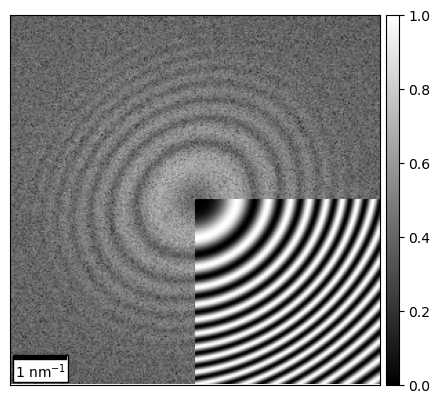

In [25]:
#fitting tilted CTF
## using new version of C2 fitting
CTF = importImageFromFile( 'FEG_CTFs\\zemlin\\12.tif' )#0.016683 0.033365
fit2DCTF( CTF, 0.026474, defocus=-360, fit_defocus=True, defocus_bounds=[-360,-340], 
          fit_C21=[False, False], C21_bounds=[0, 100, 0, np.pi], C21=[45.366, (0.84*np.pi)],
          fit_Cs=False)

In [210]:
CTF = importImageFromFile( 'FEG_CTFs\\zemlin\\03.tif' )

Cs: 1.6 mm
Defocus: -10273.988770719294 nm
C12a: 0.0 nm
C12b: 1000.0000000000001 nm


(None,)

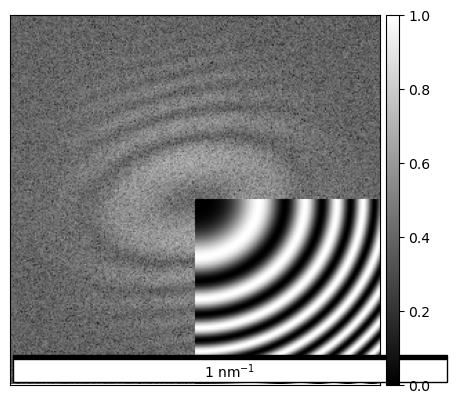

In [212]:
fit2DCTF( CTF, 0.0031972, defocus=-10000, fit_defocus=True,# defocus_bounds=[-12500,-12400], 
          fit_C21=[False, False], C21=[0, 1000]),# C21_bounds=[0, 100, 0, 100],
#          fit_Cs=False)

In [142]:
### modified to express C2 in polar rather than cartesian elements
def plot2Dfit(data, fit, scale):
    fig, ax = plt.subplots(1, 1)
    # side-by-side plot
    sbs = data
    limit=int(np.size(data,0)/2)
    #sbs[limit:,limit:] = fit[limit:,limit:]
    sbs[limit:,limit:] = fit[limit:,limit:]
    ax.imshow( sbs, cmap='grey',  extent=[-data.shape[1]/2., data.shape[1]/2., -data.shape[0]/2., data.shape[0]/2. ])
    #ax.axvline(0, 0, color='r')
    #ax.axhline(0, 0, color='r')
    ax.set_xticks([])
    ax.set_yticks([])
    from matplotlib import cm
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(cm.ScalarMappable(cmap='grey'), cax=cax )
    from mpl_toolkits.axes_grid1.anchored_artists import (AnchoredSizeBar)
    scalebar = AnchoredSizeBar(ax.transData, 1/scale, '1 nm$^{-1}$', loc='lower left', frameon=True, size_vertical=2, borderpad=0.2)
    ax.add_artist(scalebar)
    return

def plot2Dfitalt(data, fit, scale):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # side-by-side plot
    ax1.imshow( data, cmap='grey')
    ax2.imshow( fit, cmap='grey')
    return

# updated C21 from Thust et al
def modelCTF2D_new( g, phi, lamb, defocus, Cs, C12, C12phi ):
    func = np.sin( (np.pi*lamb*(g**2))*(defocus + C12*np.cos(2*(phi - C12phi))) +(0.5*np.pi*Cs*(lamb**3)*(g**4)))**2
    return func

def modelCTF2D( g, phi, lamb, defocus, Cs, C12a, C12b ):
    func = np.sin( 
        (np.pi*lamb*(g**2))*(defocus + C12a*np.sin(2*phi)+ C12b*np.cos(2*phi))
        +(0.5*np.pi*Cs*(lamb**3)*(g**4))
    )**2

def fit2DCTF( data, scale, **kwargs ):
    # scale in nm-1
    # kwargs
    fit_defocus = kwargs.get('fit_defocus', True)
    fit_Cs = kwargs.get('fit_Cs', False)
    fit_C2astig = kwargs.get('fit_C21', [False, False])
    defocus_val = kwargs.get('defocus', 0) * 1e-9
    Cs_val = kwargs.get('Cs', 1.6) *1e-3
    ###
    C21_val = kwargs.get('C21', [0.0, 0.0])
    defocus_bounds = kwargs.get('defocus_bounds', [-np.inf, np.inf])
    C2astig_bounds = kwargs.get('C21_bounds', [-np.inf, np.inf,-np.inf, np.inf])
    ###
    Cs_bounds = kwargs.get('Cs_bounds', [-np.inf, np.inf])
    # convert to SI units
    data = scaleDataRange( data )
    # x and y data for fitting function
    imageX = np.size(data,0)
    irow, icol = np.indices(data.shape)
    centX = irow - data.shape[0] / 2.0
    centY = icol - data.shape[1] / 2.0
    # distance
    iradius = ((centX**2 + centY**2)**0.5) * scale * 1e9
    # angle in radians
    itheta = np.arctan2(centX, centY)
    # make model and init values
    model2d = mdl( modelCTF2D, independent_vars=['g', 'phi'] )
    params = model2d.make_params()
    params['defocus'].vary = fit_defocus
    params['defocus'].set(value=defocus_val, min=defocus_bounds[0]*1e-9, max=defocus_bounds[1]*1e-9)
    params['lamb'].set(value=0.00251e-9)
    params['lamb'].vary = False
    params['Cs'].vary = fit_Cs
    params['Cs'].set(value=Cs_val, min=Cs_bounds[0]*1e-3, max=Cs_bounds[1]*1e-3)
    ### changed in this model ###
    params['C12a'].set(value=C21_val[0]*1e-9, min=C2astig_bounds[0]*1e-9, max=C2astig_bounds[1]*1e-9)
    params['C12a'].vary = fit_C2astig[0]
    params['C12b'].set(value=C21_val[1]*1e-9, min=C2astig_bounds[2]*1e-9, max=C2astig_bounds[3]*1e-9)
    params['C12b'].vary = fit_C2astig[1]
    ###
    # do fitting
    results_2d = model2d.fit(data, params, g=iradius, phi=itheta )
    # report the fit results
    printAberrations( results_2d )
    # plot figure
    fit = model2d.func( g=iradius, phi=itheta, **results_2d.best_values )
    plot2Dfit( data, fit, scale )
    return
    
def printAberrations( result ):
    print( 'Cs: ' + str( result.params['Cs'].value * 1e3 ) + ' mm' )
    print( 'Defocus: ' + str( result.params['defocus'].value * 1e9 ) + ' nm' )
    print( 'C12: ' + str( result.params['C12'].value * 1e9 ) + ' nm' )
    print( 'C12 angle: ' + str( result.params['C12phi'].value / np.pi ) + ' rad' )
    return

def importImageFromFile( input_image ):
    from skimage.io import imread
    return imread( input_image )
    

In [116]:
#test of least squares for aberration coeffcients 
t = np.array([10e-3, -10e-3, 20e-3, -20e-3, 5e-3, -5e-3])
coeff = np.zeros([len(t),4])
# create coeffcients matrix
for n in range(0,len(t)-1):
    coef[n,:] = np.array( [1, t[n], 2*t[n]**2, 6*t[n]**2] )
# create results matrix
results=np.array( [[-590e-9],[-590e-9],[-620e-9],[-620e-9],[-560e-9],[-560e-9]] )

aberrations = np.linalg.lstsq(coeff,results)
print(results)
print(coef)
print(aberrations)

[[-5.9e-07]
 [-5.9e-07]
 [-6.2e-07]
 [-6.2e-07]
 [-5.6e-07]
 [-5.6e-07]]
[[ 1.0e+00  1.0e-02  2.0e-04  6.0e-04]
 [ 1.0e+00 -1.0e-02  2.0e-04  6.0e-04]
 [ 1.0e+00  2.0e-02  8.0e-04  2.4e-03]
 [ 1.0e+00 -2.0e-02  8.0e-04  2.4e-03]
 [ 1.0e+00  5.0e-03  5.0e-05  1.5e-04]]
(array([[0.],
       [0.],
       [0.],
       [0.]]), array([], dtype=float64), np.int32(0), array([0., 0., 0., 0.]))
